In [1]:
## pycistarget terminal version

import warnings
warnings.simplefilter(action = 'ignore')
import pycisTopic
pycisTopic.__version__
import numpy as np
import pandas as pd

projDir = '~/CH/CH-cross/Fig3/Scenicplus/hg38/'
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
tmpDir = '~/CH/tmp/'
if not os.path.exists(tmpDir):
    os.makedirs(tmpDir)

In [2]:
## ray init
import ray
ray.shutdown()
ray.init('auto')
#ray.init(address='10.105.100.3:6379')
#assert ray.is_initialized() ==True

2023-04-16 09:00:45,441	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 210.32.148.185:6379...
2023-04-16 09:00:45,493	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [3]:
#
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.preprocessing.filtering import *

# load data
import pickle
infile = open('~/CH/CH-cross/Fig3/Scenicplus/hg38/output/hg38_cluster_cistopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

import pickle
infile = open('~/CH/CH-cross/Fig3/Scenicplus/hg38/output/DARs/Imputed_accessibility.pkl', 'rb')
imputed_acc_obj = pickle.load(infile)
infile.close()

infile = open('~/CH/CH-cross/Fig3/Scenicplus/hg38/output/pycisTarget/menr.pkl', 'rb') # change here

menr = pickle.load(infile)
infile.close()

In [4]:
## RNA 
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
import scanpy as sc
import numpy as np
rna_anndata = sc.read_loom('~/CH/CH-cross/Fig3/Scenicplus/hg38/hg38_rna_lineage_pseudo_20.loom')
rna_anndata


## Create Scenicplus object.
scplus_obj = create_SCENICPLUS_object(GEX_anndata = rna_anndata, 
                                     cisTopic_obj = cistopic_obj,
                                     imputed_acc_obj = imputed_acc_obj,
                                     menr = menr,
                                     multi_ome_mode = False,
                                     key_to_group_by = 'lineage',
                                     nr_cells_per_metacells = 5)

2023-04-16 09:13:38,098 create scenicplus object INFO     Following annotations were found in both assays under key lineage:
	Renal, Neural, Immune, Endothelial, Epithelial, Muscle, Gut, Hepatocyte, Stromal.
Keeping 2406 cells for RNA and 33084 for ATAC.
2023-04-16 09:26:58,703 create scenicplus object INFO     Automatically set `nr_metacells` to: Endothelial: 24, Epithelial: 100, Gut: 148, Hepatocyte: 8, Immune: 362, Muscle: 66, Neural: 38, Renal: 52, Stromal: 162
2023-04-16 09:26:58,706 create scenicplus object INFO     Generating pseudo multi-ome data


In [9]:
saveDir = outDir + 'scenicplus/'
if not os.path.exists(saveDir):
    os.mkdir(saveDir)

In [10]:
import scenicplus

In [11]:
from scenicplus import *

In [12]:
from scenicplus.wrappers.run_scenicplus import run_scenicplus

In [14]:
annot=pd.read_csv('./Hg38_geneanno.csv')

In [16]:
import pyranges as pr
annot_use = pr.PyRanges(annot.dropna(axis=0))

In [17]:
ucsc_assembly='hg38'
import requests
target_url = 'http://hgdownload.cse.ucsc.edu/goldenPath/{asm}/bigZips/{asm}.chrom.sizes'.format(
            asm=ucsc_assembly)
        # check wether url exists
request = requests.get(target_url)
if request.status_code == 200:
    #log.info("Downloading chromosome sizes from: {}".format(target_url))
    chromsizes = pd.read_csv(target_url, sep='\t', header=None)
    chromsizes.columns = ['Chromosome', 'End']
    chromsizes['Start'] = [0]*chromsizes.shape[0]
    chromsizes = chromsizes.loc[:, ['Chromosome', 'Start', 'End']]
if not any(['chr' in c for c in scplus_obj.region_names]):
    annot.Chromosome = annot.Chromosome.str.replace('chr', '')
    chromsizes = pr.PyRanges(chromsizes)

In [18]:
chromsizes

,Chromosome,Start,End
0,chr1,0,248956422
1,chr2,0,242193529
2,chr3,0,198295559
3,chr4,0,190214555
4,chr5,0,181538259
...,...,...,...
450,chrUn_KI270539v1,0,993
451,chrUn_KI270385v1,0,990
452,chrUn_KI270423v1,0,981
453,chrUn_KI270392v1,0,971


In [19]:
try:
    sys.stderr = open(os.devnull, "w")  # silence stderr
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['lineage'],
        species = 'hsapiens',
        ensembl_assembly=None,ucsc_assembly=None,
        pr_annot=annot_use,pr_chromsizes=chromsizes,
        tf_file = '/media/ggj/Guo-4T-AI/Scenicplus_database/allTFs_hg38.txt',
        save_path = saveDir,
        biomart_host = 'http://nov2020.archive.ensembl.org/',
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = False,
        calculate_DEGs_DARs = True,
        export_to_loom_file = False,
        export_to_UCSC_file = False,
        n_cpu = 20,ignore_reinit_error=True,
        _temp_dir = os.path.join(tmpDir, 'ray_spill'))
    sys.stderr = sys.__stderr__  # unsilence stderr
except Exception as e:
    #in case of failure, still save the object
    with open(saveDir + 'scplus_obj_pseudo_20', 'wb') as f:
        pickle.dump(scplus_obj, f)
    raise(e)

2023-04-16 09:43:37,913 SCENIC+_wrapper INFO     /media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/hg38/output/scenicplus/ folder already exists.
2023-04-16 09:43:37,914 SCENIC+_wrapper INFO     Merging cistromes
2023-04-16 09:44:03,331 SCENIC+_wrapper INFO     Getting search space
2023-04-16 09:44:06,569 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2023-04-16 09:44:08,813 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2023-04-16 09:44:22,163 R2G          INFO     Intersecting with regions.
2023-04-16 09:44:23,512 R2G          INFO     Calculating distances from region to gene
2023-04-16 09:46:54,330 R2G          INFO     Imploding multiple entries per region and gene
2023-04-16 09:52:41,714 R2G          INFO     Done!
2023-04-16 09:52:42,436 SCENIC+_wrapper INFO     Inferring region to gene relationships
2023-04-16 09:52:42

2023-04-16 10:02:13,578	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.


2023-04-16 10:05:51,360 GSEA         INFO     Subsetting TF2G adjacencies for TF with motif.


2023-04-16 10:06:01,587	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


2023-04-16 10:06:02,631 GSEA         INFO     Running GSEA...
2023-04-16 10:10:34,289 GSEA         INFO     Subsetting on adjusted pvalue: 1, minimal NES: 0 and minimal leading edge genes 10
2023-04-16 10:10:35,210 GSEA         INFO     Merging eRegulons
2023-04-16 10:10:35,400 GSEA         INFO     Storing eRegulons in .uns[eRegulons].
2023-04-16 10:10:37,199 SCENIC+_wrapper INFO     Formatting eGRNs
2023-04-16 10:12:35,675 SCENIC+_wrapper INFO     Converting eGRNs to signatures
2023-04-16 10:12:40,572 SCENIC+_wrapper INFO     Calculating eGRNs AUC
2023-04-16 10:12:40,575 SCENIC+_wrapper INFO     Calculating region ranking
2023-04-16 10:15:07,185 SCENIC+_wrapper INFO     Calculating eGRNs region based AUC
2023-04-16 10:15:41,561 SCENIC+_wrapper INFO     Calculating gene ranking
2023-04-16 10:15:41,902 SCENIC+_wrapper INFO     Calculating eGRNs gene based AUC
2023-04-16 10:16:05,245 SCENIC+_wrapper INFO     Binarizing eGRNs AUC
2023-04-16 10:21:04,153 SCENIC+_wrapper INFO     Making eG

... storing 'lineage' as categorical


2023-04-16 10:21:31,962 SCENIC+      INFO     Finished calculating DEGs for variable lineage
2023-04-16 10:21:31,963 SCENIC+      INFO     Calculating DARs for variable lineage
2023-04-16 10:21:55,269 SCENIC+      INFO     There are 86750 variable features


... storing 'lineage' as categorical


2023-04-16 10:22:08,624 SCENIC+      INFO     Finished calculating DARs for variable lineage
2023-04-16 10:22:08,627 SCENIC+_wrapper INFO     Saving object
2023-04-16 10:27:28,032 SCENIC+_wrapper INFO     Finished! Took 43.8353262146314 minutes


# Downstream analysis

In [3]:
## pycistarget terminal version

import warnings
warnings.simplefilter(action = 'ignore')
import pycisTopic
pycisTopic.__version__
import numpy as np
import pandas as pd

projDir = '~/CH/CH-cross/Fig3/Scenicplus/hg38/'
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
tmpDir = '~/CH/tmp/'
if not os.path.exists(tmpDir):
    os.makedirs(tmpDir)

In [15]:
## ray init
import ray
ray.init('auto')
#ray.init(address='10.105.100.3:6379')
#assert ray.is_initialized() ==True

Python version:,3.8.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [6]:
saveDir = outDir + 'scenicplus/'
if not os.path.exists(saveDir):
    os.mkdir(saveDir)

In [7]:
# Downstream analysis
import pickle
infile = open(saveDir + 'scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [20]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)
scplus_obj.uns['eRegulon_metadata_filtered'].head()

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,ARID5B_+_(51r),ARID5B_+_(29g),ARID5B,False,chr9:14205510-14206010,NFIB,0.002039,0.699714,0.001427,0.001427,6.615955,1,0.655524,4.336916,4.336916,ARID5B_+_+
1,ARID5B_+_(51r),ARID5B_+_(29g),ARID5B,False,chr16:72927518-72928018,ZFHX3,0.002659,0.066003,0.000176,0.000176,3.231401,1,0.616499,1.992157,1.992157,ARID5B_+_+
2,ARID5B_+_(51r),ARID5B_+_(29g),ARID5B,False,chr16:73232479-73232979,ZFHX3,0.004067,0.459412,0.001868,0.001868,3.231401,1,0.616499,1.992157,1.992157,ARID5B_+_+
3,ARID5B_+_(51r),ARID5B_+_(29g),ARID5B,False,chr16:73020337-73020837,ZFHX3,0.001252,0.295546,0.000370,0.000370,3.231401,1,0.616499,1.992157,1.992157,ARID5B_+_+
4,ARID5B_+_(51r),ARID5B_+_(29g),ARID5B,False,chr19:3374563-3375063,NFIC,0.003015,0.392943,0.001185,0.001185,1.664883,1,0.415209,0.691274,0.691274,ARID5B_+_+


In [9]:
scplus_obj.uns['eRegulon_metadata_filtered'].to_csv(saveDir + 'eRegulon_metadata_filtered.csv')
scplus_obj.uns['eRegulon_metadata'].to_csv(saveDir + 'eRegulon_metadata.csv')

In [21]:
import dill
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(saveDir,  'region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(saveDir, 'gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function

In [22]:
#auc
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.1,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.1,
                normalize= False,
                n_cpu = 5)

In [24]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = False,
            variable = 'lineage',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = False,
            variable = 'lineage',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

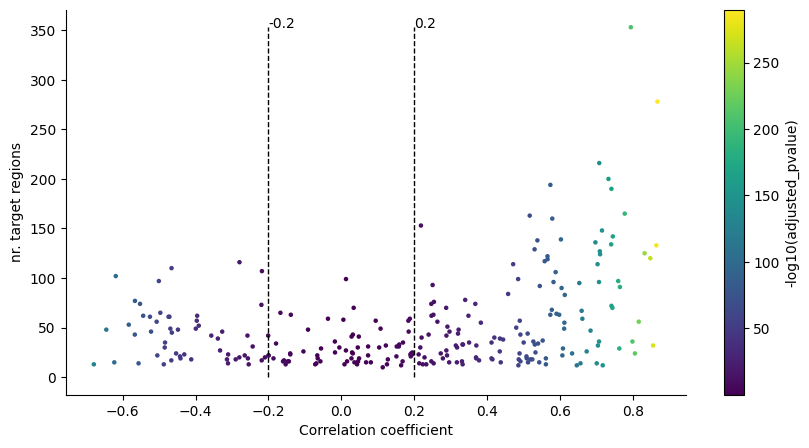

In [25]:
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.2, 0.2],
        'n_targets': 0
}
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [26]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 196 eRegulons


#from scenicplus.cistromes import cistrome_correlation
cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'lineage',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key1= 'Gene_based',
            signature_key2= 'Region_based',
            out_key= 'filtered_gene_region')

In [27]:
from scenicplus.plotting.dotplot import generate_dotplot_df
plotting_df = generate_dotplot_df(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'],
        color_matrix = scplus_obj.to_df('EXP'),
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'lineage',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'])
tmp = plotting_df[['index', 'eRegulon_name', 'color_val']
        ].pivot_table(index = 'index', columns = 'eRegulon_name'
        ).fillna(0)['color_val']
tmp
idx_max = tmp.idxmax(axis = 0)
order = pd.concat([idx_max[idx_max == x] for x in tmp.index.tolist() if len(plotting_df[plotting_df == x]) > 0]).index.tolist()
plotting_df['eRegulon_name'] = pd.Categorical(plotting_df['eRegulon_name'], categories = order)
plotting_df['repressor_activator'] = ['activator' if '+' in n.split('_')[1] and 'extended' not in n or '+' in n.split('_')[2] and 'extended' in n  else 'repressor' for n in plotting_df['eRegulon_name']]
plotting_df.to_csv('./human_tfdf_pseudo_20_total.csv')

In [28]:
import dill
dill.dump(scplus_obj, open(os.path.join(saveDir, 'scplus_obj_total.pkl'), 'wb'), protocol=-1)